# Loan Prediction Based on Customer Behavior

## Importing Libraries

In [1]:
!pip install hmeasure


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from itertools import combinations
from scipy.stats import chi2_contingency, pearsonr
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from collections import Counter
from hmeasure import h_score
import xgboost as xgb
import shap
import geopandas as gpd

## A) Diving Deeper in the Dataset

In [4]:
# reading the dataset

training_df = pd.read_csv("./archive/Training Data.csv")

### A-1) Getting Info from the Dataset

In [5]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [6]:
training_df.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [7]:
training_df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


### A-2) Changing Some Columns for Later

In [8]:
# transform all column names to lowercase for better harmony

training_df.columns = training_df.columns.str.lower()

In [9]:
# rename marrid/single column to marital_status

training_df.rename(columns={'married/single': 'marital_status'}, inplace=True)

In [10]:
# It is better to set a column as index for the datasets. "Id" column would be a good choice.

training_df = training_df.set_index('id')

### A-3) Finding non-unique values in each category

In [11]:
training_df.nunique()

income               41920
age                     59
experience              21
marital_status           2
house_ownership          3
car_ownership            2
profession              51
city                   317
state                   29
current_job_yrs         15
current_house_yrs        5
risk_flag                2
dtype: int64

### A-4) Finding NaN values for each category

In [12]:
training_df.isna().sum()

income               0
age                  0
experience           0
marital_status       0
house_ownership      0
car_ownership        0
profession           0
city                 0
state                0
current_job_yrs      0
current_house_yrs    0
risk_flag            0
dtype: int64

There is no missing value, thank God! :D We do not need to fill or drop NaNs.

### A-5) Checking Object Columns to See Whether They Need Cleaning

In [13]:
training_df['city'].unique()

array(['Rewa', 'Parbhani', 'Alappuzha', 'Bhubaneswar',
       'Tiruchirappalli[10]', 'Jalgaon', 'Tiruppur', 'Jamnagar',
       'Kota[6]', 'Karimnagar', 'Hajipur[31]', 'Adoni', 'Erode[17]',
       'Kollam', 'Madurai', 'Anantapuram[24]', 'Kamarhati', 'Bhusawal',
       'Sirsa', 'Amaravati', 'Secunderabad', 'Ahmedabad', 'Ajmer',
       'Ongole', 'Miryalaguda', 'Ambattur', 'Indore', 'Pondicherry',
       'Shimoga', 'Chennai', 'Gulbarga', 'Khammam', 'Saharanpur',
       'Gopalpur', 'Amravati', 'Udupi', 'Howrah', 'Aurangabad[39]',
       'Hospet', 'Shimla', 'Khandwa', 'Bidhannagar', 'Bellary', 'Danapur',
       'Purnia[26]', 'Bijapur', 'Patiala', 'Malda', 'Sagar', 'Durgapur',
       'Junagadh', 'Singrauli', 'Agartala', 'Thanjavur', 'Hindupur',
       'Naihati', 'North_Dumdum', 'Panchkula', 'Anantapur', 'Serampore',
       'Bathinda', 'Nadiad', 'Kanpur', 'Haridwar', 'Berhampur',
       'Jamshedpur', 'Hyderabad', 'Bidar', 'Kottayam', 'Solapur',
       'Suryapet', 'Aizawl', 'Asansol', 'Deoghar'

In [14]:
training_df['state'].unique()

array(['Madhya_Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh',
       'West_Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

There are some weird `city` and `state` names which should be handled.

In [15]:
training_df['house_ownership'].unique()

array(['rented', 'norent_noown', 'owned'], dtype=object)

There are 3 types of house ownership as shown above.

In [16]:
training_df['house_ownership'].value_counts()

house_ownership
rented          231898
owned            12918
norent_noown      7184
Name: count, dtype: int64

The number of `norent_noown` may be because of customer living with their parents and house owned by their parents.

In [17]:
training_df['car_ownership'].unique()

array(['no', 'yes'], dtype=object)

A person does or does not have a car (binary class)

In [18]:
training_df['profession'].unique()

array(['Mechanical_engineer', 'Software_Developer', 'Technical_writer',
       'Civil_servant', 'Librarian', 'Economist', 'Flight_attendant',
       'Architect', 'Designer', 'Physician', 'Financial_Analyst',
       'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
       'Surveyor', 'Design_Engineer', 'Chemical_engineer',
       'Hotel_Manager', 'Dentist', 'Comedian', 'Biomedical_Engineer',
       'Graphic_Designer', 'Computer_hardware_engineer',
       'Petroleum_Engineer', 'Secretary', 'Computer_operator',
       'Chartered_Accountant', 'Technician', 'Microbiologist',
       'Fashion_Designer', 'Aviator', 'Psychologist', 'Magistrate',
       'Lawyer', 'Firefighter', 'Engineer', 'Official', 'Analyst',
       'Geologist', 'Drafter', 'Statistician', 'Web_designer',
       'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
       'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
      dtype=object)

There are no weird names, so we do not need any filtering for this column.

### A-6) Removing Duplicates

In [19]:
duplicate_rows = training_df[training_df.duplicated(keep=False)]
duplicate_rows.shape

(215993, 12)

In [20]:
training_df = training_df.drop_duplicates(keep='first')

In [21]:
training_df.shape

(43190, 12)

Only 43,000 of 252,000 records were unique.

## B) Data Cleaning

### B-1) Cleaning Cateogrical Columns (city and state)

In [22]:
# clean the city and state name and remove non-alphabetic characters

training_df['city'] = training_df['city'].str.replace('[^A-Za-z]', '', regex=True)
training_df['state'] = training_df['state'].str.replace('[^A-Za-z]', '', regex=True)

In [23]:
training_df['city'].unique()

array(['Rewa', 'Parbhani', 'Alappuzha', 'Bhubaneswar', 'Tiruchirappalli',
       'Jalgaon', 'Tiruppur', 'Jamnagar', 'Kota', 'Karimnagar', 'Hajipur',
       'Adoni', 'Erode', 'Kollam', 'Madurai', 'Anantapuram', 'Kamarhati',
       'Bhusawal', 'Sirsa', 'Amaravati', 'Secunderabad', 'Ahmedabad',
       'Ajmer', 'Ongole', 'Miryalaguda', 'Ambattur', 'Indore',
       'Pondicherry', 'Shimoga', 'Chennai', 'Gulbarga', 'Khammam',
       'Saharanpur', 'Gopalpur', 'Amravati', 'Udupi', 'Howrah',
       'Aurangabad', 'Hospet', 'Shimla', 'Khandwa', 'Bidhannagar',
       'Bellary', 'Danapur', 'Purnia', 'Bijapur', 'Patiala', 'Malda',
       'Sagar', 'Durgapur', 'Junagadh', 'Singrauli', 'Agartala',
       'Thanjavur', 'Hindupur', 'Naihati', 'NorthDumdum', 'Panchkula',
       'Anantapur', 'Serampore', 'Bathinda', 'Nadiad', 'Kanpur',
       'Haridwar', 'Berhampur', 'Jamshedpur', 'Hyderabad', 'Bidar',
       'Kottayam', 'Solapur', 'Suryapet', 'Aizawl', 'Asansol', 'Deoghar',
       'Eluru', 'Ulhasnagar', 'Al

In [24]:
training_df['state'] = training_df['state'].astype(str).str.strip()
training_df.state.unique()

array(['MadhyaPradesh', 'Maharashtra', 'Kerala', 'Odisha', 'TamilNadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'AndhraPradesh',
       'WestBengal', 'Haryana', 'Puducherry', 'Karnataka', 'UttarPradesh',
       'HimachalPradesh', 'Punjab', 'Tripura', 'Uttarakhand', 'Jharkhand',
       'Mizoram', 'Assam', 'JammuandKashmir', 'Delhi', 'Chhattisgarh',
       'Chandigarh', 'Manipur', 'Sikkim'], dtype=object)

Successfully cleaned!

In [25]:
training_df.tail()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,risk_flag
id,,,,,,,,,,,,
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,WestBengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,MadhyaPradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,KalyanDombivli,Maharashtra,7,12,0
251999,6507128,45,0,single,rented,no,Graphic_Designer,Pondicherry,Puducherry,0,10,0
252000,9070230,70,17,single,rented,no,Statistician,Avadi,TamilNadu,7,11,0


## C) Exploratory Data Analysis (EDA): In this part, I will show various plots and draw conclusion of each. Also, I will check if there is any correlations.

### C-1) Univariate Analysis:
First, let's have a univariate analysis. I will show bar chart and box plot of following features: `income`, `age`, `experience`, `current_job_yrs`, `current_house_yrs`.

C:\Users\hsham\AppData\Local\Temp\ipykernel_18692\362072257.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_risk = training_df.groupby(bins)['risk_flag'].mean()
C:\Users\hsham\AppData\Local\Temp\ipykernel_18692\362072257.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_risk = training_df.groupby(bins)['risk_flag'].mean()
C:\Users\hsham\AppData\Local\Temp\ipykernel_18692\362072257.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

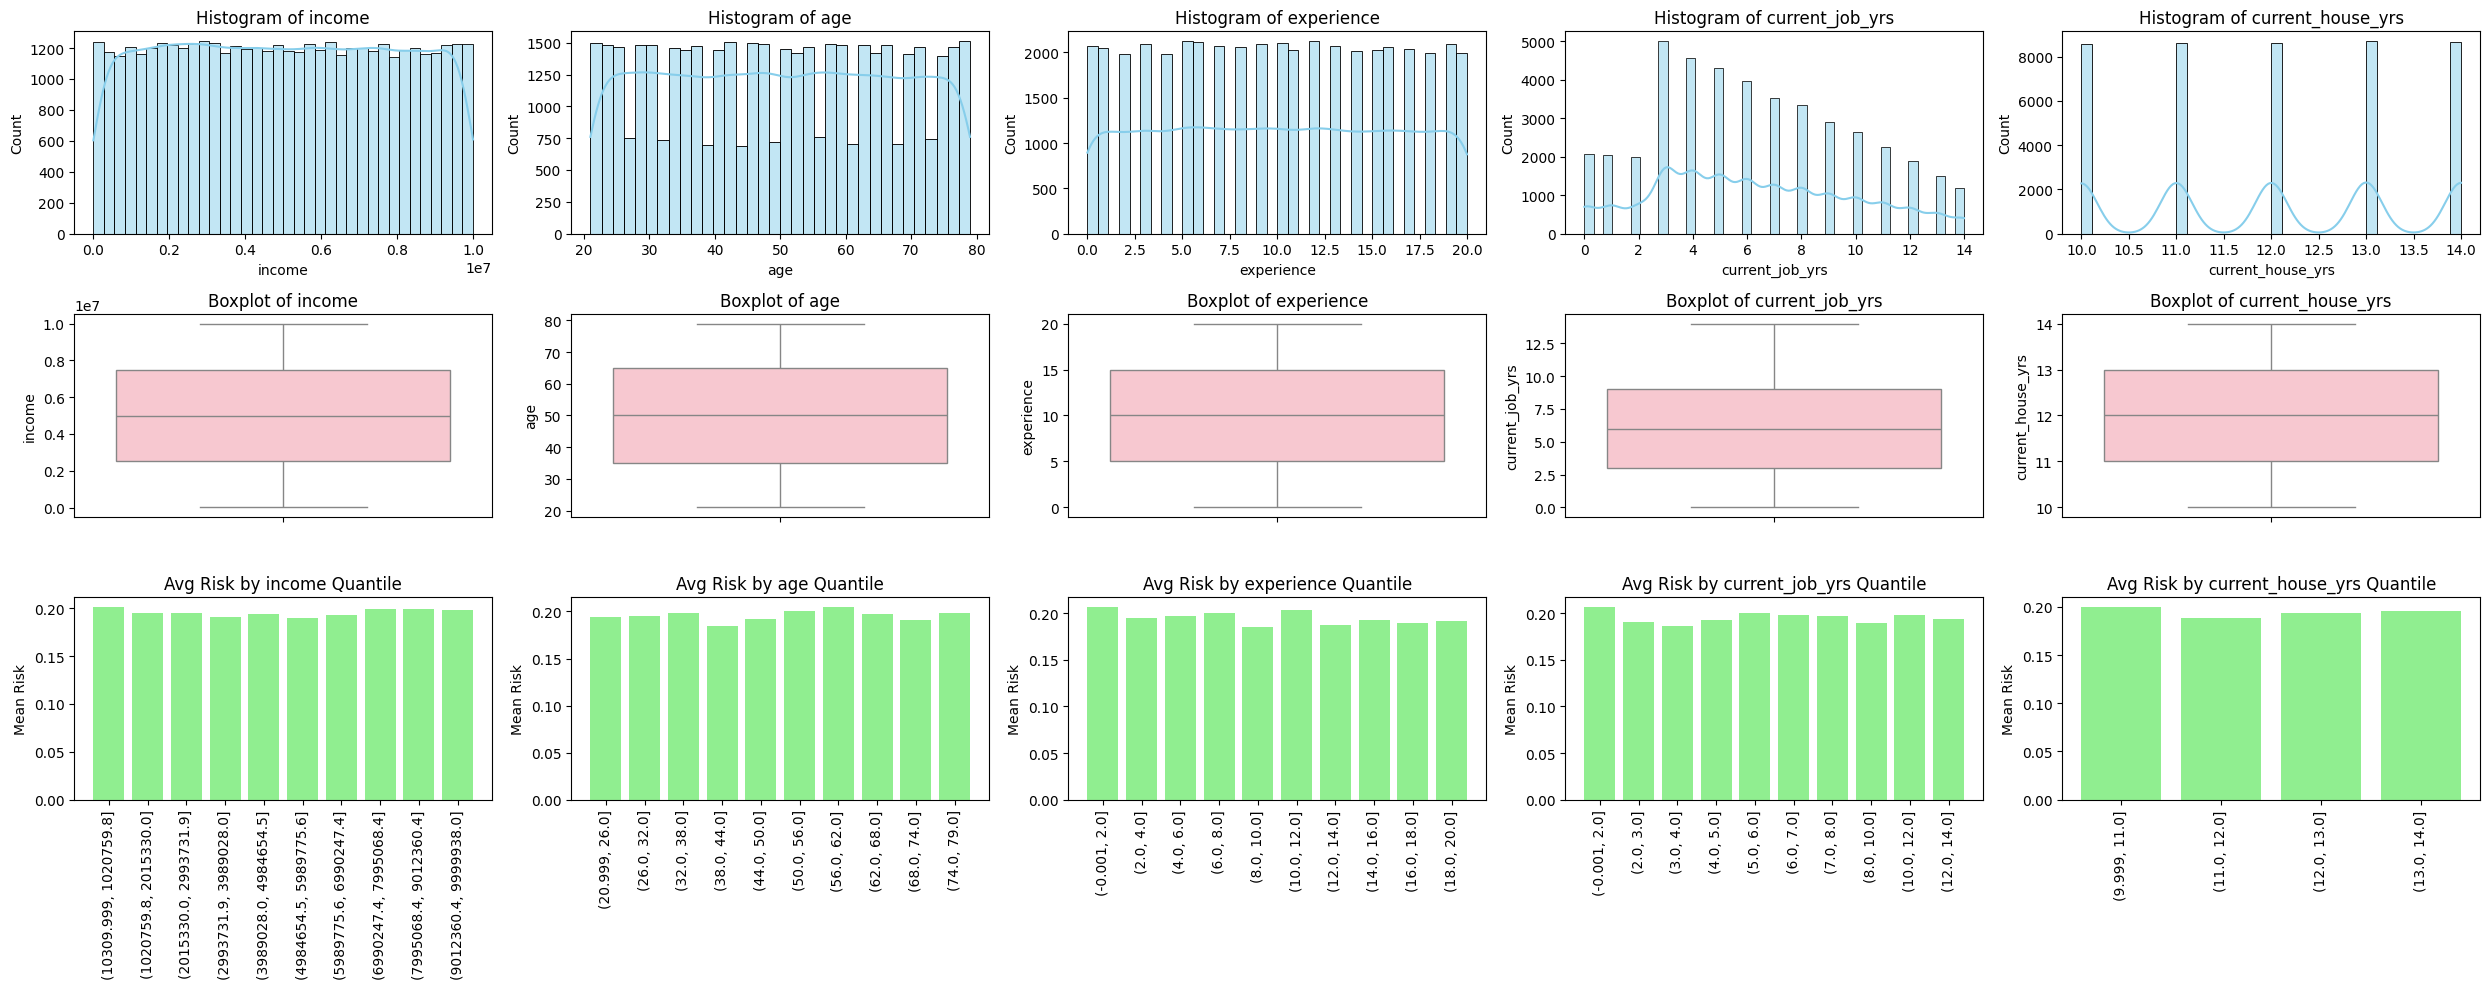

In [26]:
num_cols = ['income', 'age', 'experience', 'current_job_yrs', 'current_house_yrs']
n_cols = len(num_cols)

fig, axes = plt.subplots(3, n_cols, figsize=(5 * n_cols, 10))

# histograms are plotted in first row and corresponding box plots are plotted in second row and barplots in third row
for i, col in enumerate(num_cols):
    # histograms
    sb.histplot(training_df[col], kde=True, ax=axes[0, i], color='skyblue')
    axes[0, i].set_title(f'Histogram of {col}')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Count')

    # boxplots
    sb.boxplot(y=training_df[col], ax=axes[1, i], color='pink')
    axes[1, i].set_title(f'Boxplot of {col}')
    axes[1, i].set_ylabel(col)

    # barplot
    bins = pd.qcut(training_df[col], q=10, duplicates='drop')
    mean_risk = training_df.groupby(bins)['risk_flag'].mean()
    axes[2, i].bar(mean_risk.index.astype(str), mean_risk.values, color='lightgreen')
    axes[2, i].set_title(f'Avg Risk by {col} Quantile')
    axes[2, i].set_ylabel('Mean Risk')
    axes[2, i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### **Conclusion:**
- **`income` feature:**  
Almost uniformly distributed; median is 5M. No clear outliers. Risk is stable across income levels, suggesting income alone is not predictive.

- **`age` feature:**  
Fairly uniform from 20–80, median is 55. No significant outliers. Risk is nearly flat across age groups, slightly higher in 56–62.

- **`experience` feature:**  
Uniformly distributed (0–20 years), median is 10. Risk slightly decreases with more experience.

- **`current_job_yrs` feature:**  
Right-skewed; most have <5 years. Median is 7. No strong correlation between tenure and risk, though 4–6 yrs shows slightly higher risk.

- **`current_house_years` feature:**  
Values limited to 10–14; likely synthetic. Risk is almost constant, offering little predictive value.


#### Age Type: New feature!

In [27]:
def age_type(age):
    if age > 19 and  age <= 29:
        return 'Young'
    elif age > 29 and age <= 39:
        return 'Adults'
    elif age > 39 and age <= 60:
        return 'Middle'
    else:
        return 'Old'

training_df['age_type'] = training_df.age.map(age_type)
training_df.age_type.value_counts()

age_type
Middle    15419
Old       13798
Adults     7286
Young      6687
Name: count, dtype: int64

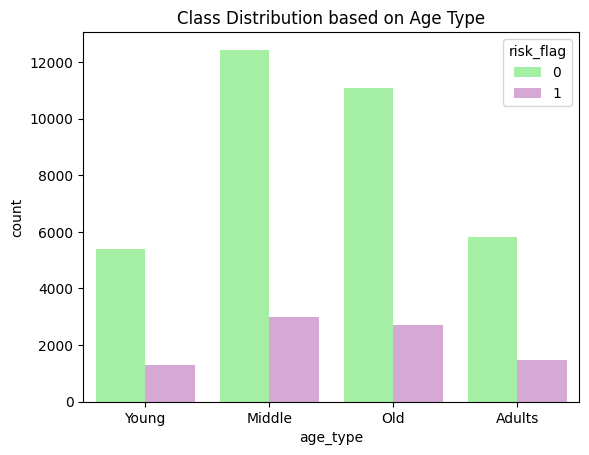

In [28]:
sb.countplot(x='age_type', data=training_df, hue='risk_flag', palette=['palegreen', 'plum'])
plt.title('Class Distribution based on Age Type')
plt.show()

In [29]:
print(f'Total defaulters based on age_type \n')
print(pd.crosstab(training_df['age_type'], training_df['risk_flag'], margins='True'))
print("="*50)
print(f'Proportion of defaulters based on age_type\n')
print(pd.pivot_table(data=training_df, index='age_type', values='risk_flag', aggfunc=np.mean, columns=None,sort=True))

Total defaulters based on age_type 

risk_flag      0     1    All
age_type                     
Adults      5823  1463   7286
Middle     12431  2988  15419
Old        11090  2708  13798
Young       5403  1284   6687
All        34747  8443  43190
Proportion of defaulters based on age_type

          risk_flag
age_type           
Adults     0.200796
Middle     0.193787
Old        0.196260
Young      0.192014


C:\Users\hsham\AppData\Local\Temp\ipykernel_18692\1559718878.py:5: FutureWarning: The provided callable <function mean at 0x000001AB6FA24400> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  print(pd.pivot_table(data=training_df, index='age_type', values='risk_flag', aggfunc=np.mean, columns=None,sort=True))


#### **Conclusion:**
There are about 15,419 customers in the "Middle Age" group, 13,798 in the "Old" group, 7,286 adults, and 6,687 young customers.
When we compare the default rates, adult customers have the highest default rate at 20%, while younger customers have the lowest at 19.2%.

### Risk Flag

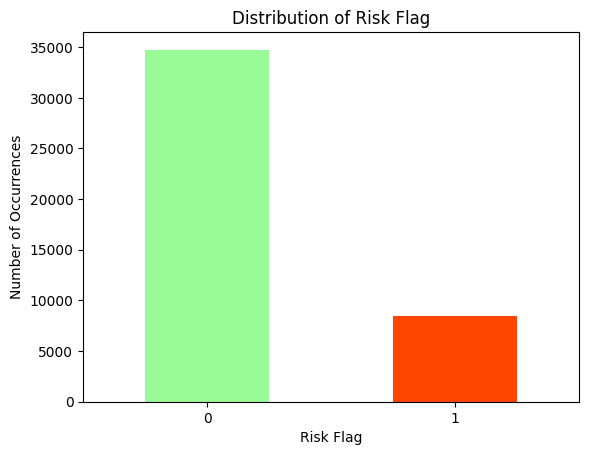

In [30]:
risk_dist = training_df['risk_flag'].value_counts()
risk_dist.plot(kind='bar', color=['palegreen', 'orangered'])
plt.xlabel('Risk Flag')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Risk Flag')
plt.xticks(rotation=0)
plt.show()

#### **Conclusion:**
As we can see, there is a remarkable class imbalance here. This gives me this solution to use oversampling for the lower class in the rest of the code. `SMOTEENN` would be a good choice to overcome this obstacle.

### C-2) Bivariate Analysis:
At second step, we will have a bivariate analysis:

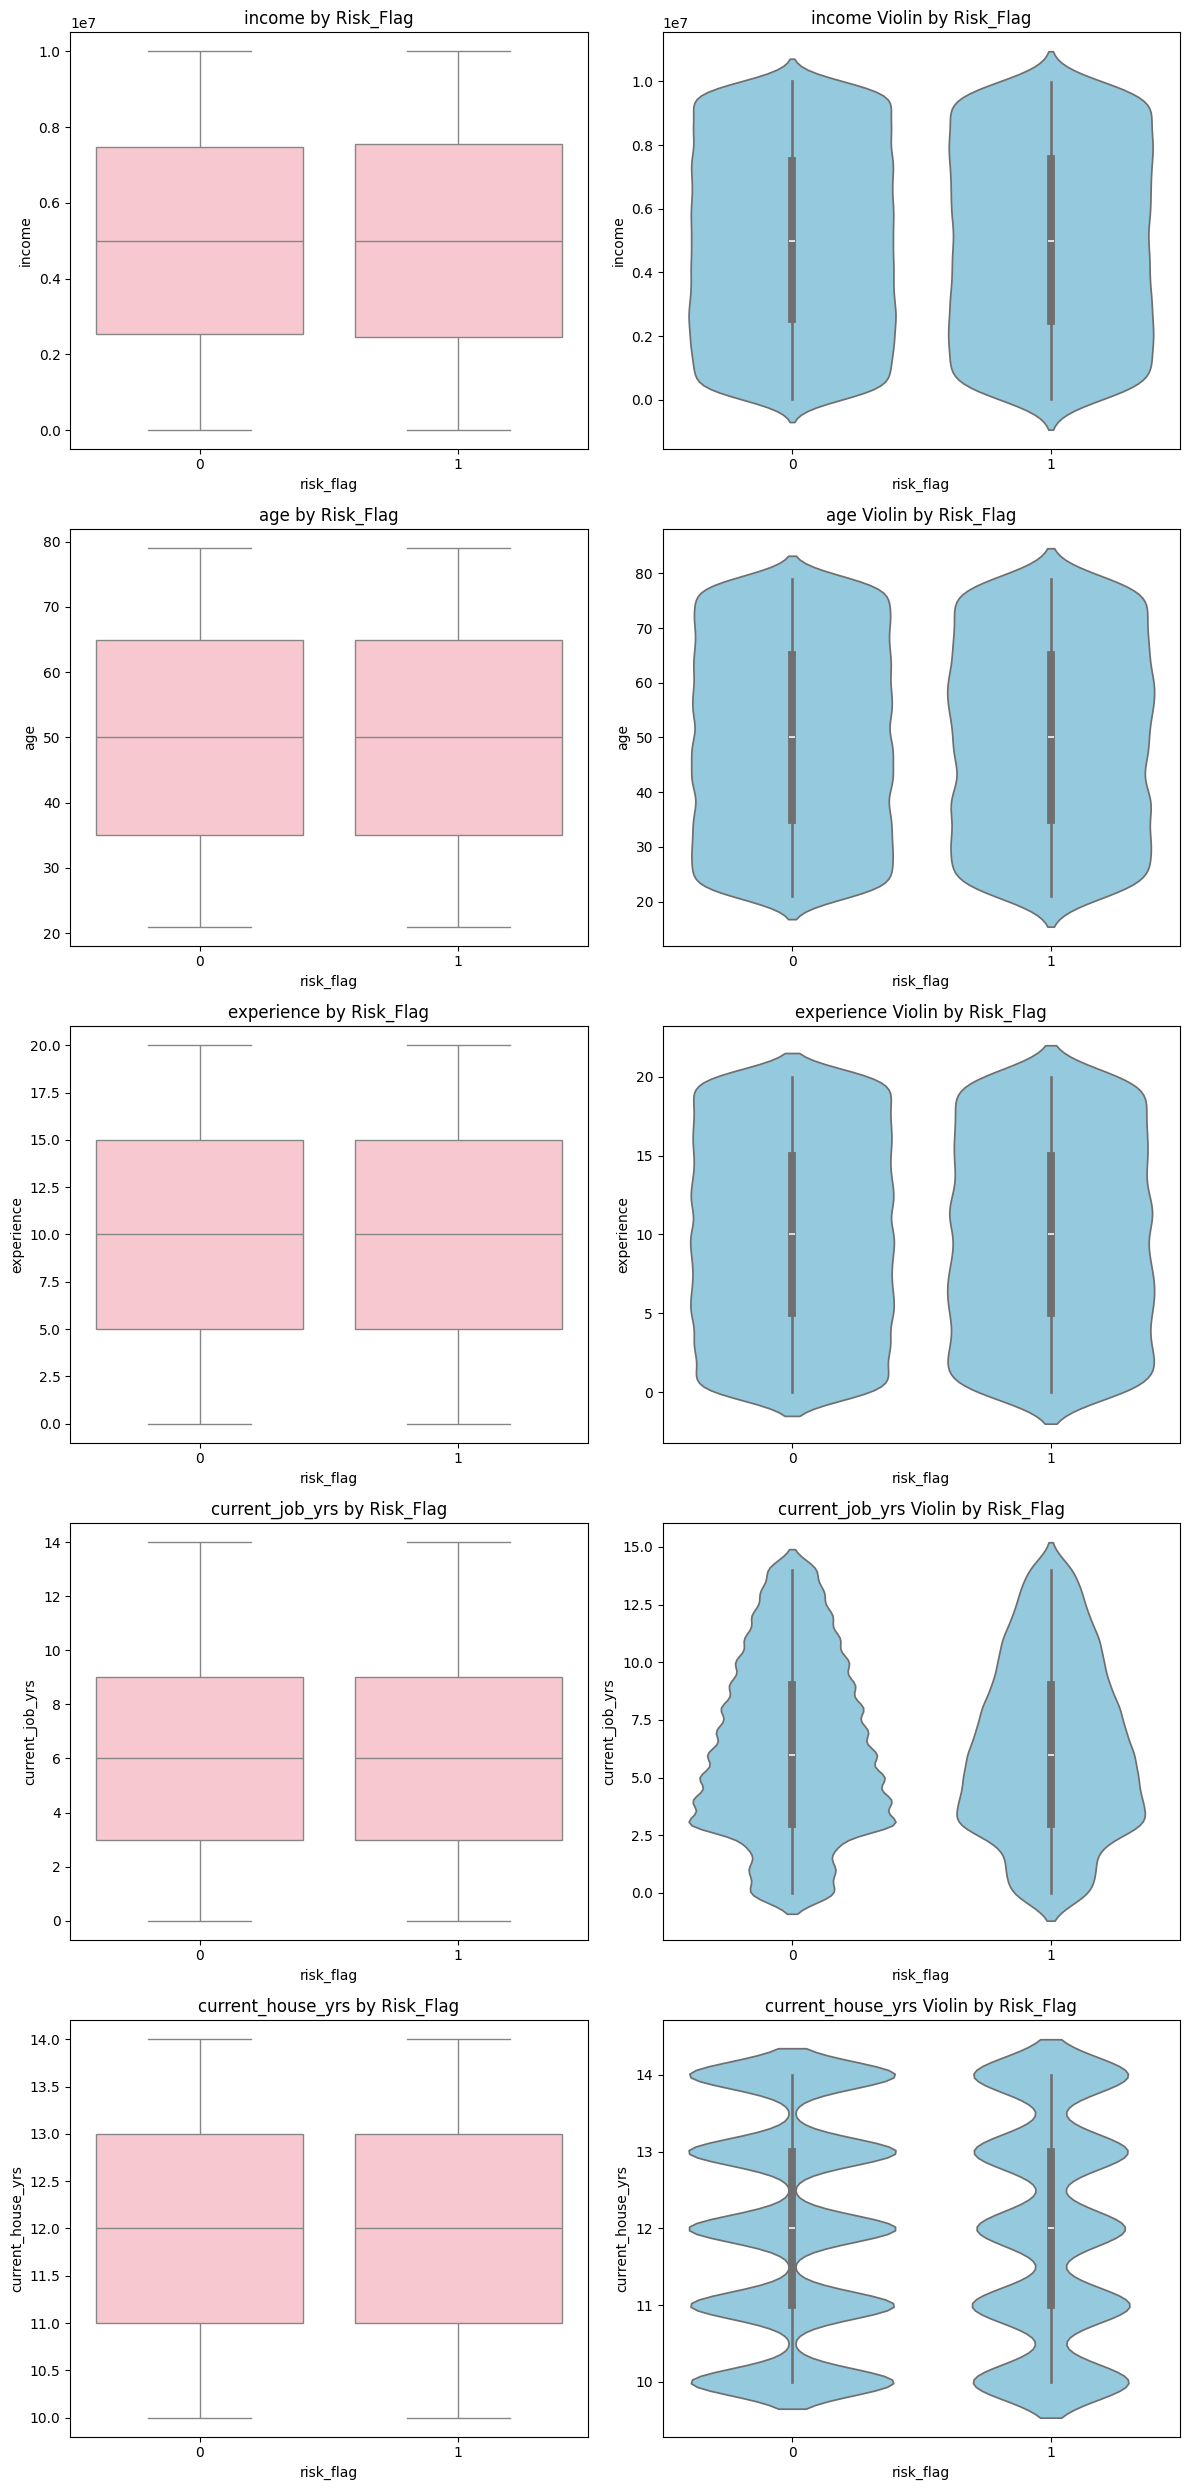

In [31]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 5 * len(num_cols)))

# box plots are plotted in first column and corresponding violin plots are plotted in second column
for i, col in enumerate(num_cols):
    # box plot
    sb.boxplot(x='risk_flag', y=col, data=training_df, ax=axes[i, 0], color='pink')
    axes[i, 0].set_title(f'{col} by Risk_Flag')
    axes[i, 0].set_xlabel('risk_flag')
    axes[i, 0].set_ylabel(col)

    # violin plot
    sb.violinplot(x='risk_flag', y=col, data=training_df, ax=axes[i, 1], color='skyblue')
    axes[i, 1].set_title(f'{col} Violin by Risk_Flag')
    axes[i, 1].set_xlabel('risk_flag')
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.show()

#### Now we move on to categorical data: `marital_status`, `house_ownership`, `car_ownership`

Count Plot of 'marital_status' Feature:


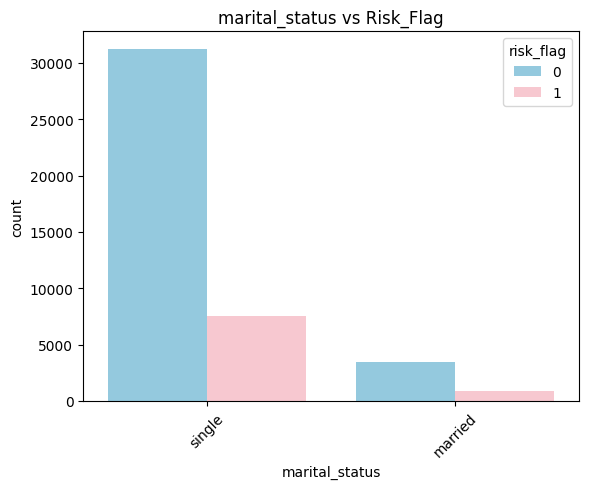

Count Plot of 'house_ownership' Feature:


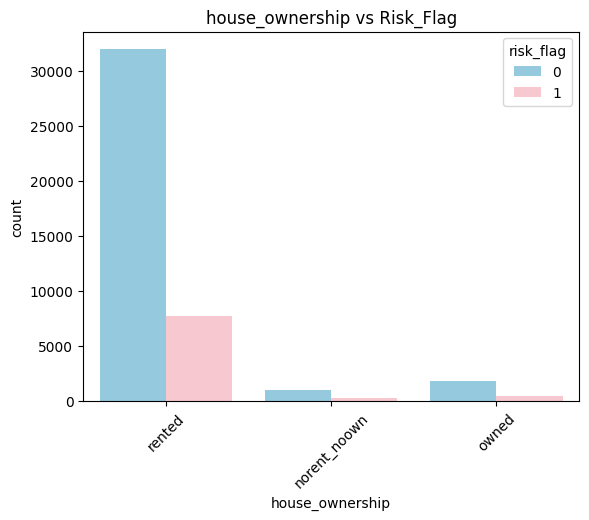

Count Plot of 'car_ownership' Feature:


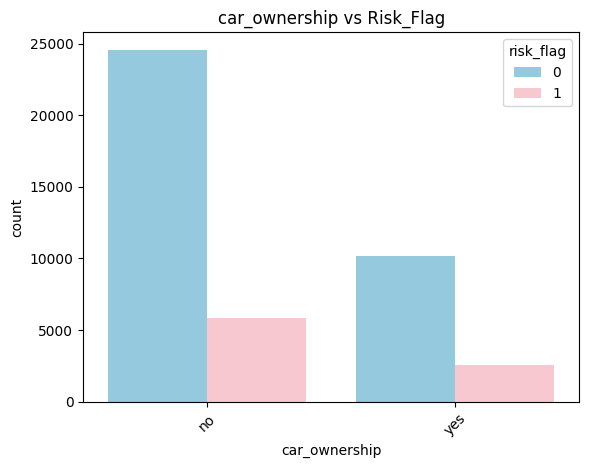

In [32]:
# countplot vs Risk_Flag
custom_palette = ['skyblue', 'pink']
cat_cols = ['marital_status', 'house_ownership', 'car_ownership']
for col in cat_cols:
    print(f"Count Plot of '{col}' Feature:")
    sb.countplot(x=col, hue='risk_flag', data=training_df, palette=custom_palette)
    plt.title(f'{col} vs Risk_Flag')
    plt.xticks(rotation=45)
    plt.show()

#### **Conclusion:**
- **`marital_status` feature**:
Most people in the dataset are single, and most of the defaulters are also single. Married people are fewer, and they have fewer defaults. This means married people may be a little more likely to pay back their loans.

- **`house_ownership` feature**:
Most people live in rented houses, and most defaulters are also renters. People who own their homes (especially fully owned) have fewer defaults. This shows that owning a house might be a sign of better money stability.

- **`car_ownership` feature**:
More people without a car default on their loans compared to people who have a car. This could mean that owning a car is a small sign that someone can manage their money better.


### Let's see which professions are most likely to default:

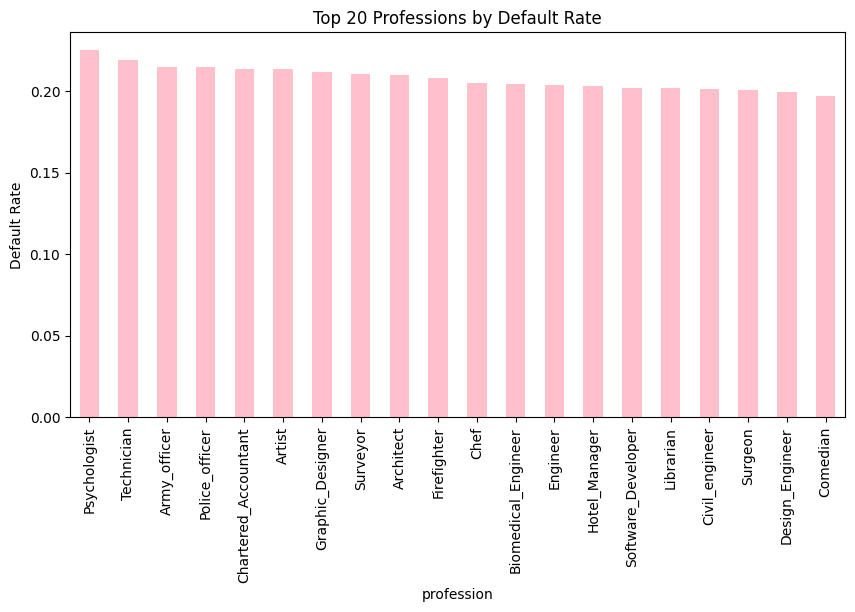

In [33]:
top_prof_risk = (training_df.groupby('profession')['risk_flag'].mean().sort_values(ascending=False).head(20))
top_prof_risk.plot(kind='bar', color='pink', figsize=(10, 5), title="Top 20 Professions by Default Rate")
plt.ylabel("Default Rate")
plt.show()

#### **Conclusion:**
Some jobs like psychologists, technicians, army officers and police officers have higher loan default rates. Job title alone does not always tell us if someone will pay back their loan. It is better to use job along with other features to predict defaults.

#### Which states are most likely to default:

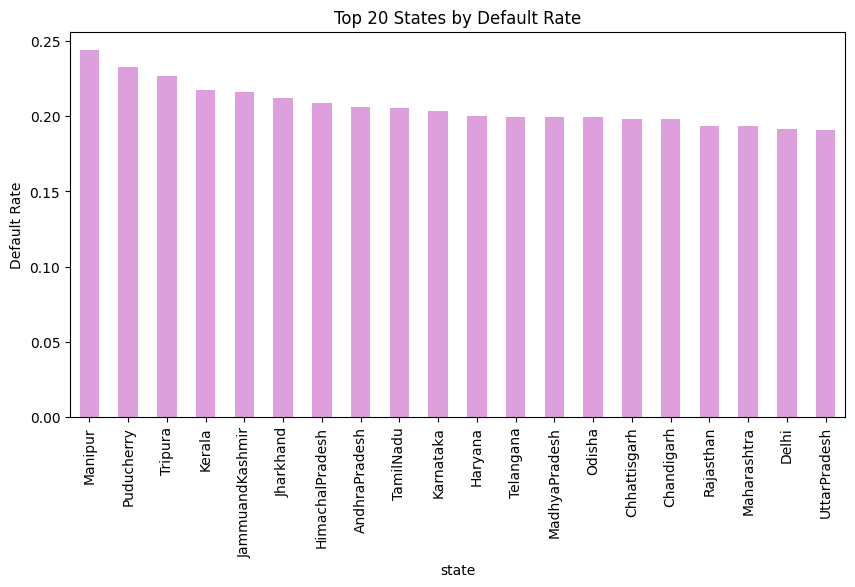

In [34]:
top_prof_risk = (training_df.groupby('state')['risk_flag'].mean().sort_values(ascending=False).head(20))
top_prof_risk.plot(kind='bar', color='plum', figsize=(10, 5), title="Top 20 States by Default Rate")
plt.ylabel("Default Rate")
plt.show()

#### **Conclusion:**
Manipur, Puducherry, and Tripura are the top 3 states in terms of default rate.

### C-3) Correlations

#### Heatmap: Correlation between numerical features

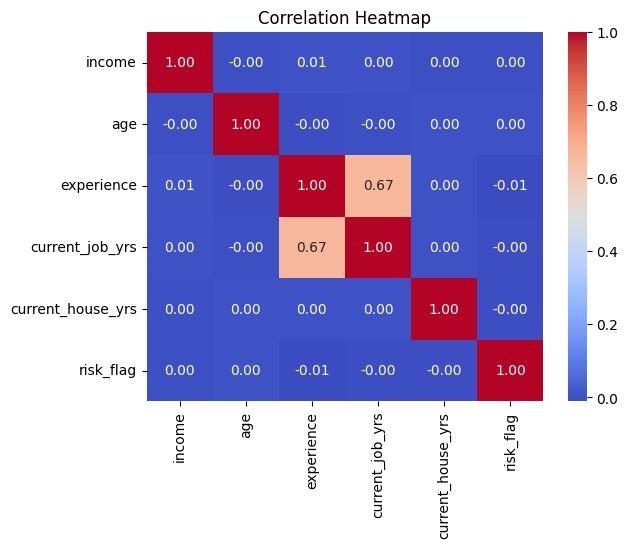

In [186]:
sb.heatmap(training_df[num_cols + ['risk_flag']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

#### **Conclusion:**
As we can see, none of the features have strong correlation with `risk_flag`. The values are very close to 0, which means features like `income`, `age`, and `experience` do not directly explain who will default. The only strong relationship is between `experience` and `current job years` (correlation = 0.67), which makes sense because people with more experience usually have longer job history.
PS: We know that the correlation between two features range from -1 to +1. More positive number shows positive correlation (increase in one feature results in increase in the other one), and more negative number shows negative correlation (increase in one feature results in decrease in the other one). If the number is close to 0, this shows no significant correlation.

#### Binned Age/Income Default Rate Heatmap

C:\Users\hsham\AppData\Local\Temp\ipykernel_4520\1413450810.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = training_df.pivot_table(index='age_bin', columns='income_bin', values='risk_flag', aggfunc='mean')


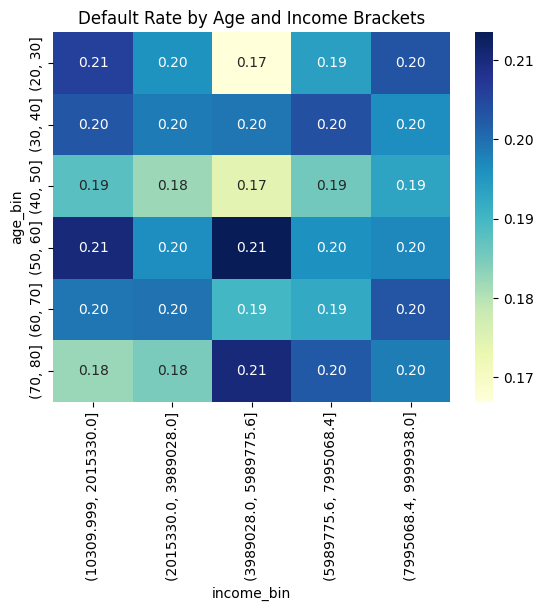

In [187]:
training_df['age_bin'] = pd.cut(training_df['age'], bins=[20, 30, 40, 50, 60, 70, 80])
training_df['income_bin'] = pd.qcut(training_df['income'], q=5)

heatmap_data = training_df.pivot_table(index='age_bin', columns='income_bin', values='risk_flag', aggfunc='mean')
sb.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Default Rate by Age and Income Brackets")
plt.show()

#### **Conclusion:**
People aged 20–30 show slightly higher default rates, especially in the lowest income group. However, the difference is not very large across age or income bins (most values fall between 0.17 and 0.21).
The lowest default rates appear in the mid-income range (38M to 60M) for some age groups, especially age 40–50, suggesting that people in this range may be more financially stable.
Interestingly, people aged 50–60 and 70-80 have relatively high default rates, even in mid-to-high income brackets, which is unexpected.
Overall, combining age and income gives a better understanding of default risk than looking at each one separately. These features together can be useful in a predictive model, but the patterns are not very strong or linear.

#### R-Value and P-Value

In [188]:
quantitative_columns = training_df.select_dtypes(include=['int', 'float']).columns
for col1, col2 in combinations(quantitative_columns, 2):
    r, p = pearsonr(training_df[col1], training_df[col2])

    if p < 0.05:
        print(f"Significant correlation between '{col1}' and '{col2}'")
        print(f"    Pearson r = {r:.4f}, p-value = {p:.4f}")
        print("-" * 50)
    else:
        print(f"No significant correlation between '{col1}' and '{col2}' (p = {p:.4f})")
        print("-" * 50)

No significant correlation between 'income' and 'age' (p = 0.8432)
--------------------------------------------------
No significant correlation between 'income' and 'experience' (p = 0.0901)
--------------------------------------------------
No significant correlation between 'income' and 'current_job_yrs' (p = 0.5831)
--------------------------------------------------
No significant correlation between 'income' and 'current_house_yrs' (p = 0.9401)
--------------------------------------------------
No significant correlation between 'income' and 'risk_flag' (p = 0.9128)
--------------------------------------------------
No significant correlation between 'age' and 'experience' (p = 0.3089)
--------------------------------------------------
No significant correlation between 'age' and 'current_job_yrs' (p = 0.5970)
--------------------------------------------------
No significant correlation between 'age' and 'current_house_yrs' (p = 0.5040)
--------------------------------------------

#### **Conclusion:**
No major predictive relationships seem to be between `income`, `age`, or `years at job/house` with `risk_flag`.
Only `experience` shows any real connection with `current_job_yrs`, and very weakly with `risk_flag`.

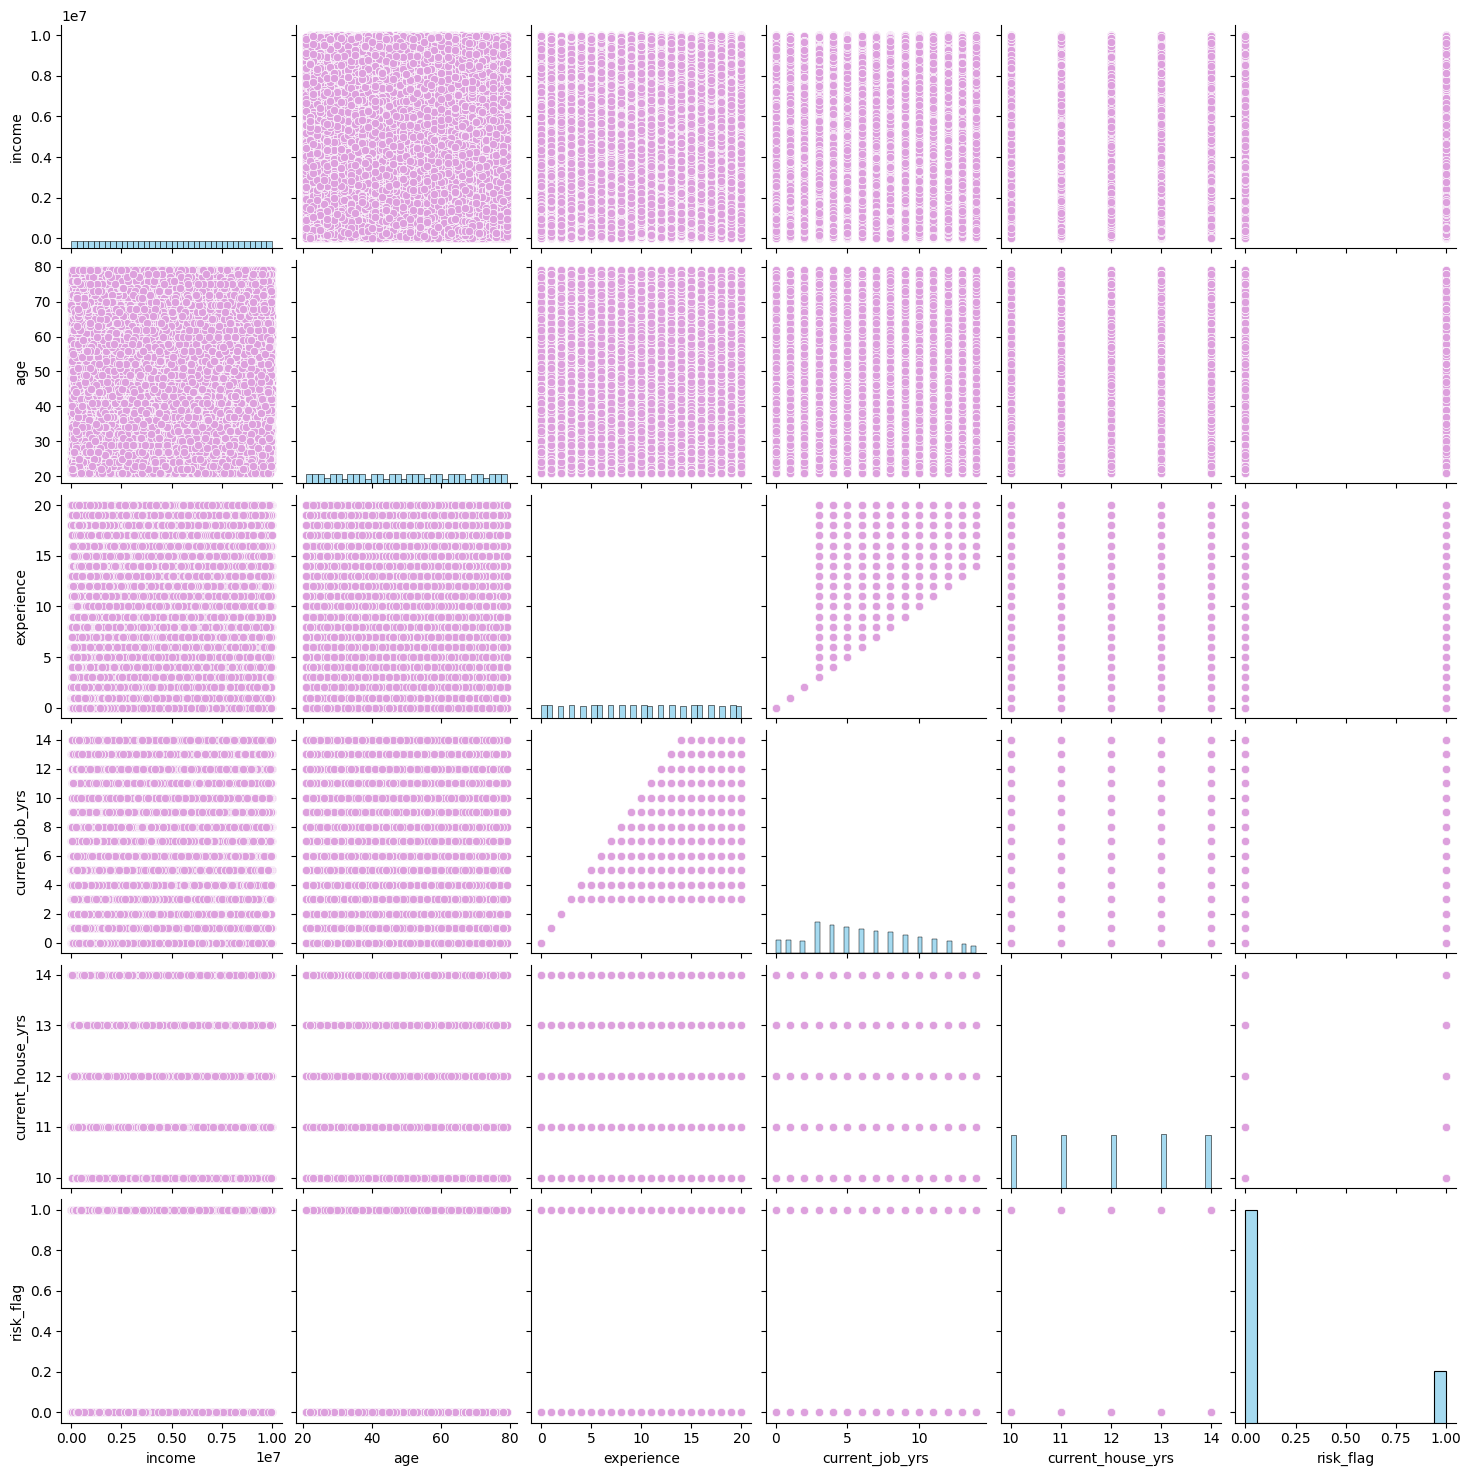

In [189]:
sb.pairplot(training_df.select_dtypes(include=['int','float']), plot_kws={'color': 'plum'},  diag_kws={'color': 'skyblue'})
plt.show()

#### **Conclusion:**
Most features like `income`, `age`, and `experience` do not show clear patterns — they are not linearly related to each other or to default (`risk_flag`). The only strong relationship is between `experience` and `current_job_yrs`.
Also, the chart shows that most people in the dataset are non-defaulters, so the data is imbalanced. Overall, single features may not predict default well on their own.

#### Chi-Square Test: This helps us find out whether 2 categorical features have correlation.

In [190]:
# names of all categorical columns
categorical_columns = training_df.select_dtypes(include=['object', 'category']).columns

for col1, col2 in combinations(categorical_columns, 2):
    print(f"\nContingency Table for '{col1}' and '{col2}':")

    # frequency table showing how often each combination occurs
    contingency_table = pd.crosstab(training_df[col1], training_df[col2])
    print(contingency_table)

    # Chi-square test of independence
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    total = contingency_table.sum().sum()

    min_dimension = min(contingency_table.shape) - 1

    # Cramer's V
    if min_dimension > 0:
        cramers_v = (chi2 / (total * min_dimension)) ** 0.5
    else:
        cramers_v = 0

    print(f"\nChi-square Statistic = {chi2:.3f}")
    print(f"P-value = {p_value:.3f}")
    print(f"Cramer's V = {cramers_v:.3f}")
    print("-" * 50)



Contingency Table for 'marital_status' and 'house_ownership':
house_ownership  norent_noown  owned  rented
marital_status                              
married                   109    222    4029
single                   1158   2022   35650

Chi-square Statistic = 3.361
P-value = 0.186
Cramer's V = 0.009
--------------------------------------------------

Contingency Table for 'marital_status' and 'car_ownership':
car_ownership      no    yes
marital_status              
married          3069   1291
single          27353  11477

Chi-square Statistic = 0.003
P-value = 0.956
Cramer's V = 0.000
--------------------------------------------------

Contingency Table for 'marital_status' and 'profession':
profession      Air_traffic_controller  Analyst  Architect  Army_officer  \
marital_status                                                             
married                             88       81         87            73   
single                             813      762        728    

In [191]:
categorical_columns

Index(['marital_status', 'house_ownership', 'car_ownership', 'profession',
       'city', 'state', 'age_type', 'age_bin', 'income_bin'],
      dtype='object')

#### **Conclusion:**
The results show that most relationships between variables like `marital_status`, `house_ownership`, `car_ownership`, `profession`, `income`, and `age` are either not significant or very weak. This means that, for example, whether someone is married does not really affect their house or car ownership, income, or profession.
The only strong relationship found was between `city` and `state`, which is expected since every city belongs to one state. Because of this, it is safe to remove one of them (city or state) from modeling to avoid redundancy.
In short, most categorical features in the dataset are independent of each other, and their relationships are too weak to be useful for predicting outcomes. This suggests we should treat each feature on its own rather than expecting strong connections between them.

In [192]:
training_df.head()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,risk_flag,age_type,age_bin,income_bin
id,,,,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,MadhyaPradesh,3,13,0,Young,"(20, 30]","(10309.999, 2015330.0]"
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,Middle,"(30, 40]","(5989775.6, 7995068.4]"
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Old,"(60, 70]","(3989028.0, 5989775.6]"
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Middle,"(40, 50]","(5989775.6, 7995068.4]"
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli,TamilNadu,3,14,1,Middle,"(40, 50]","(3989028.0, 5989775.6]"


## D) Feature Engineering

In [193]:
training_df.drop(['current_job_yrs'], axis=1, inplace=True)

In [194]:
training_df.drop(columns=['age_bin', 'income_bin'],  axis=1, inplace=True)

In [195]:
training_df.shape

(43190, 12)

### D-1) Splitting

In [211]:
X = training_df.drop('risk_flag', axis=1)
y = training_df['risk_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

### D-2) Encoding

In [212]:
def fit_response_encoding(feature, alpha=1):
    counts = X_train[feature].value_counts()
    encoding = {}
    for category, total in counts.items():
        class_probs = []
        for label in [0, 1]:
            class_count = len(X_train[(X_train[feature] == category) & (y_train == label)])
            smoothed = (class_count + alpha * 10) / (total + alpha * 20)
            class_probs.append(smoothed)
        encoding[category] = class_probs
    return encoding

def transform_response_encoding(feature, data, alpha=1):
    encoding = fit_response_encoding(feature, alpha)
    return np.array([encoding.get(cat, [0.5, 0.5]) for cat in data])


In [213]:
X_train_state_re = transform_response_encoding('state', X_train['state'])
X_test_state_re = transform_response_encoding('state', X_test['state'])
X_train_city_re = transform_response_encoding('city', X_train['city'])
X_test_city_re = transform_response_encoding('city', X_test['city'])
X_train_prof_re = transform_response_encoding('profession', X_train['profession'])
X_test_prof_re = transform_response_encoding('profession', X_test['profession'])

In [214]:
map_dicts = {
    'house_ownership': {'rented': 0, 'owned': 1, 'norent_noown': 2},
    'car_ownership': {'no': 0, 'yes': 1},
    'marital_status': {'single': 0, 'married': 1},
    'age_type': {'Middle': 2, 'Old': 3, 'Adults': 1, 'Young': 0},
}

for col, mapping in map_dicts.items():
    X_train[col] = X_train[col].map(mapping)
    X_test[col] = X_test[col].map(mapping)

X_train_le = X_train[['house_ownership', 'car_ownership', 'marital_status', 'age_type']].values
X_test_le = X_test[['house_ownership', 'car_ownership', 'marital_status', 'age_type']].values

In [215]:
X_train.head()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_house_yrs,age_type
id,,,,,,,,,,,
238579,6685191,35,12,0,0,0,Official,Erode,TamilNadu,11,1
250326,8627640,53,20,0,0,0,Official,Srikakulam,AndhraPradesh,12,2
224367,7819272,59,8,0,0,0,Fashion_Designer,Rajkot,Gujarat,10,2
551,8900631,47,6,0,0,0,Fashion_Designer,Thiruvananthapuram,Kerala,12,2
234673,5655988,34,17,0,0,0,Graphic_Designer,Bellary,Karnataka,13,1


### D-3) Normalization and Scaling

In [216]:
# normalization
def normalize_feature(train_col, test_col):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_col.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_col.values.reshape(-1, 1))
    return train_scaled, test_scaled

In [217]:
X_train_age_norm, X_test_age_norm = normalize_feature(X_train['age'], X_test['age'])
X_train_exp_norm, X_test_exp_norm = normalize_feature(X_train['experience'], X_test['experience'])
X_train_inc_norm, X_test_inc_norm = normalize_feature(X_train['income'], X_test['income'])
X_train_yrs_norm, X_test_yrs_norm = normalize_feature(X_train['current_house_yrs'], X_test['current_house_yrs'])

In [218]:
X_train_combined = np.hstack([
    X_train_state_re, X_train_city_re, X_train_prof_re,
    X_train_le, X_train_age_norm, X_train_exp_norm,
    X_train_inc_norm, X_train_yrs_norm
])

X_test_combined = np.hstack([
    X_test_state_re, X_test_city_re, X_test_prof_re,
    X_test_le, X_test_age_norm, X_test_exp_norm,
    X_test_inc_norm, X_test_yrs_norm
])

In [220]:
columns = [
    'state_re_0', 'state_re_1', 'city_re_0', 'city_re_1', 'profession_re_0', 'profession_re_1',
    'house_ownership_le', 'car_ownership_le', 'marital_status_le', 'age_type_le',
    'age_norm', 'experience_norm', 'income_norm', 'current_house_yrs_norm'
]

X_train_stack_df = pd.DataFrame(X_train_combined, columns=columns)
X_test_stack_df = pd.DataFrame(X_test_combined, columns=columns)

print('Final training shape:', X_train_stack_df.shape, y_train.shape)
print('Final test shape:', X_test_stack_df.shape, y_test.shape)

Final training shape: (32392, 14) (32392,)
Final test shape: (10798, 14) (10798,)


In [221]:
X_train_stack_df.head()

,state_re_0,state_re_1,city_re_0,city_re_1,profession_re_0,profession_re_1,house_ownership_le,car_ownership_le,marital_status_le,age_type_le,age_norm,experience_norm,income_norm,current_house_yrs_norm
0,0.788453,0.211547,0.769231,0.230769,0.807069,0.192931,0.0,0.0,0.0,1.0,0.241379,0.60,0.668169,0.25
1,0.790798,0.209202,0.708738,0.291262,0.807069,0.192931,0.0,0.0,0.0,2.0,0.551724,1.00,0.862623,0.50
2,0.811321,0.188679,0.706422,0.293578,0.805970,0.194030,0.0,0.0,0.0,2.0,0.655172,0.40,0.781699,0.00
3,0.779528,0.220472,0.760563,0.239437,0.805970,0.194030,0.0,0.0,0.0,2.0,0.448276,0.30,0.889951,0.50
4,0.788723,0.211277,0.766667,0.233333,0.789474,0.210526,0.0,0.0,0.0,1.0,0.224138,0.85,0.565138,0.75


## E) Modeling

In [222]:
# dummy model:
y_pred_list = []
for value in range(y_test.shape[0]):
    y_pred = np.random.randint(0,1)
    y_pred_list.append(y_pred)
y_true = np.array(y_test.values)
print('roc_auc_score for dummy Model is {:.4f}'.format(roc_auc_score(y_true, y_pred_list)))

roc_auc_score for dummy Model is 0.5000


### E-1) Feature Selection

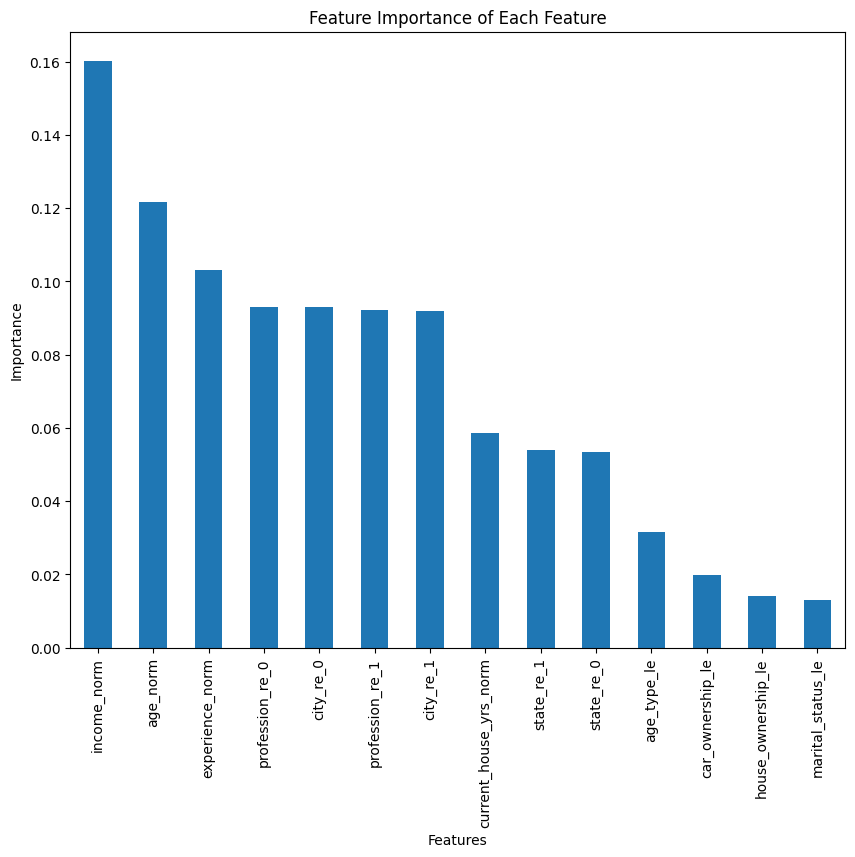

In [223]:
classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1)
top_features = SelectFromModel(classifier, threshold=-np.inf)
classifier.fit(X_train_stack_df, y_train)
plt.figure(figsize=(10,8))
plt.title('Feature Importance of Each Feature')
pd.Series(classifier.feature_importances_, index=columns).sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#### **Conclusion:**
The chart shows that `income` is the most important factor in predicting loan defaults. `Age` and `experience` also matter a lot, meaning older and more experienced people may default less. `City` and `profession` have a moderate impact, suggesting where someone lives and what they do for work affects risk. The number of years in the current house also helps a bit. On the other hand, features like `state`, `house ownership`, and `car ownership` are less useful. `Marital status` and `age group type` matter the least, showing that personal details do not help much in predicting default.

In [224]:
X_train_stack_df.columns

Index(['state_re_0', 'state_re_1', 'city_re_0', 'city_re_1', 'profession_re_0',
       'profession_re_1', 'house_ownership_le', 'car_ownership_le',
       'marital_status_le', 'age_type_le', 'age_norm', 'experience_norm',
       'income_norm', 'current_house_yrs_norm'],
      dtype='object')

### E-2) `SMOTEENN`: handling data imbalance

In [225]:
X_train_stack_df.isna().sum()

state_re_0                0
state_re_1                0
city_re_0                 0
city_re_1                 0
profession_re_0           0
profession_re_1           0
house_ownership_le        0
car_ownership_le          0
marital_status_le         0
age_type_le               0
age_norm                  0
experience_norm           0
income_norm               0
current_house_yrs_norm    0
dtype: int64

In [227]:
smote_enn = SMOTEENN()

print("Before SMOTE-ENN sampling:", Counter(y_train))

X_train_resample, y_train_resample = smote_enn.fit_resample(X_train_stack_df, y_train.ravel())

print("After SMOTE-ENN sampling:", Counter(y_train_resample))

# apply SMOTE-ENN to test data (usually not recommended, but included here for consistency)
X_test_resample, y_test_resample = smote_enn.fit_resample(X_test_stack_df, y_test.ravel())


Before SMOTE-ENN sampling: Counter({0: 26060, 1: 6332})


C:\Users\hsham\AppData\Local\Temp\ipykernel_4520\3449175990.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_resample, y_train_resample = smote_enn.fit_resample(X_train_stack_df, y_train.ravel())


After SMOTE-ENN sampling: Counter({1: 17935, 0: 10129})


C:\Users\hsham\AppData\Local\Temp\ipykernel_4520\3449175990.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_resample, y_test_resample = smote_enn.fit_resample(X_test_stack_df, y_test.ravel())


### E-3) Auxilary Functions

In [229]:
# find best threshold based on TPR*(1-FPR)
def get_best_threshold(thresholds, fpr, tpr):
    best_index = np.argmax(tpr * (1 - fpr))
    best_thresh = thresholds[best_index]
    print(f"Best TPR*(1-FPR): {tpr[best_index]*(1 - fpr[best_index]):.4f} at threshold = {best_thresh:.3f}")
    return best_thresh

# convert predicted probabilities to binary labels using a custom threshold
def apply_threshold(probs, threshold):
    return [1 if p >= threshold else 0 for p in probs]

# plot ROC curve and confusion matrix, and print classification report
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # predict probabilities
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # ROC Curves
    fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_proba)

    # plot ROC
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc(fpr_train, tpr_train):.4f}")
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc(fpr_test, tpr_test):.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # H-measure
    h_train = h_score(y_train, y_train_proba)
    h_test = h_score(y_test, y_test_proba)
    print(f"H-measure (Train): {h_train:.4f}")
    print(f"H-measure (Test) : {h_test:.4f}")

    # train confusion matrix
    best_thresh_train = get_best_threshold(thresh_train, fpr_train, tpr_train)
    y_train_pred = apply_threshold(y_train_proba, best_thresh_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    sb.heatmap(cm_train, annot=True, fmt='g', cmap='YlGnBu')
    plt.title("Train Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # test Confusion Matrix
    best_thresh_test = get_best_threshold(thresh_test, fpr_test, tpr_test)
    y_test_pred = apply_threshold(y_test_proba, best_thresh_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sb.heatmap(cm_test, annot=True, fmt='g', cmap='YlGnBu')
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # classification report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

### E-4) Logistic Regression

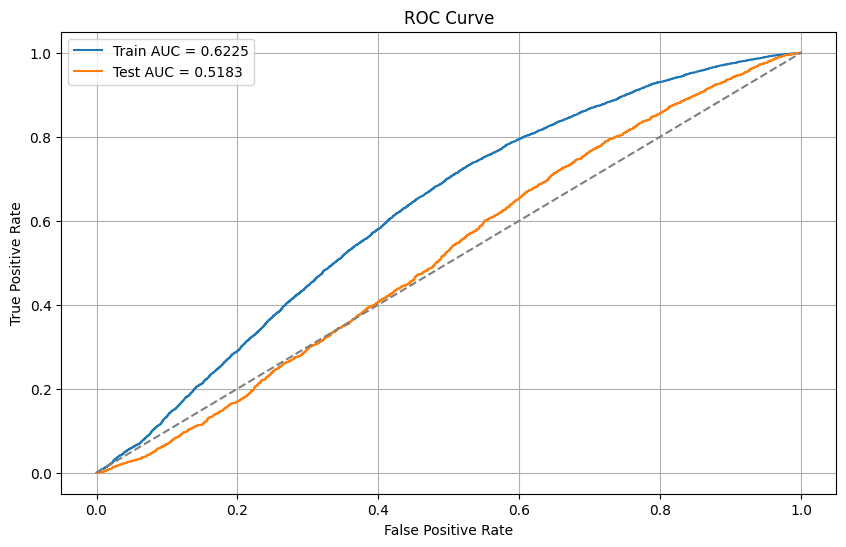

H-measure (Train): 0.0683
H-measure (Test) : 0.0121
Best TPR*(1-FPR): 0.3555 at threshold = 0.482


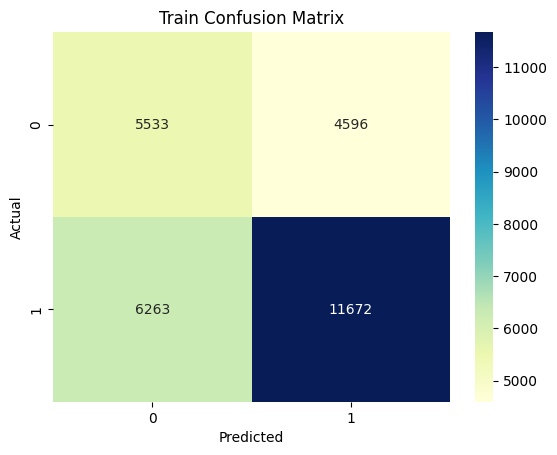

Best TPR*(1-FPR): 0.2694 at threshold = 0.471


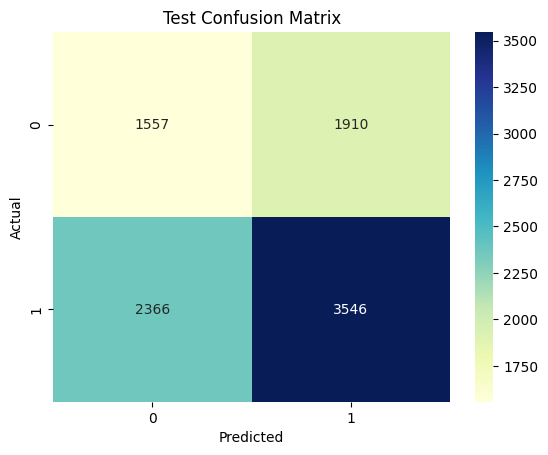

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.40      0.45      0.42      3467
           1       0.65      0.60      0.62      5912

    accuracy                           0.54      9379
   macro avg       0.52      0.52      0.52      9379
weighted avg       0.56      0.54      0.55      9379

best parameter grid : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
best score : 0.6216169805537951


In [230]:
# define parameter grid
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

# GridSearchCV for logistic regression
log_reg_cv = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

# train the model on SMOTE-ENN sampled data
log_reg_cv.fit(X_train_resample, y_train_resample)

evaluate_model(log_reg_cv, X_train_resample, y_train_resample, X_test_resample, y_test_resample)

print('best parameter grid :', log_reg_cv.best_params_)
print('best score :',log_reg_cv.best_score_)

### E-5) Decision Tree

c:\Users\hsham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
111 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hsham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hsham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\hsham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

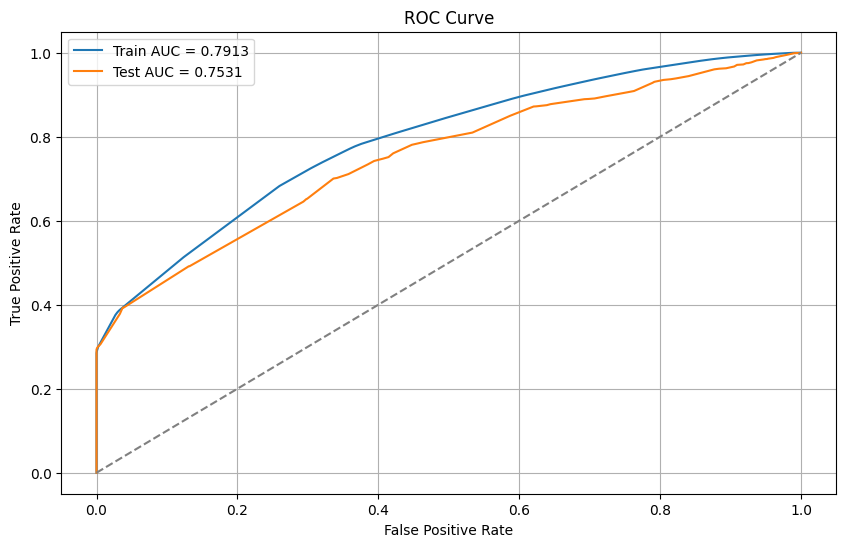

Best TPR*(1-FPR): 0.5054 at threshold = 0.491


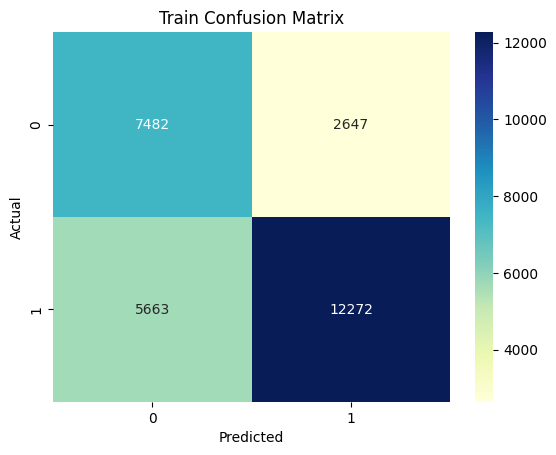

Best TPR*(1-FPR): 0.4649 at threshold = 0.486


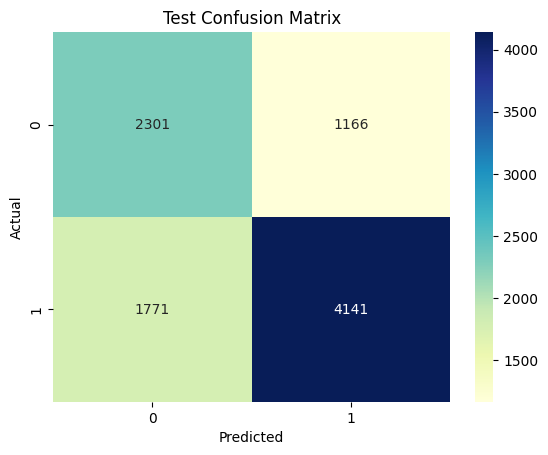

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      3467
           1       0.78      0.70      0.74      5912

    accuracy                           0.69      9379
   macro avg       0.67      0.68      0.67      9379
weighted avg       0.70      0.69      0.69      9379

H-measure (Train): 0.2677
H-measure (Test) : 0.2234
Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 125}
Best Cross-Validation Score (AUC): 0.7701


In [231]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [50, 75, 100, 125],
    'max_features': ['auto', 'sqrt', 'log2']
}
dt_model = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)


dt_model.fit(X_train_resample, y_train_resample)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_proba)

    # ROC Curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc(fpr_train, tpr_train):.4f}")
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc(fpr_test, tpr_test):.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Best threshold
    def get_best_threshold(thresholds, fpr, tpr):
        idx = np.argmax(tpr * (1 - fpr))
        print(f"Best TPR*(1-FPR): {tpr[idx]*(1 - fpr[idx]):.4f} at threshold = {thresholds[idx]:.3f}")
        return thresholds[idx]

    def apply_threshold(probs, threshold):
        return [1 if p >= threshold else 0 for p in probs]

    best_thresh_train = get_best_threshold(thresh_train, fpr_train, tpr_train)
    y_train_pred = apply_threshold(y_train_proba, best_thresh_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    sb.heatmap(cm_train, annot=True, fmt='g', cmap='YlGnBu')
    plt.title("Train Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    best_thresh_test = get_best_threshold(thresh_test, fpr_test, tpr_test)
    y_test_pred = apply_threshold(y_test_proba, best_thresh_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sb.heatmap(cm_test, annot=True, fmt='g', cmap='YlGnBu')
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    # H-Measure
    h_train = h_score(y_train, y_train_proba)
    h_test = h_score(y_test, y_test_proba)
    print(f"H-measure (Train): {h_train:.4f}")
    print(f"H-measure (Test) : {h_test:.4f}")


evaluate_model(dt_model, X_train_resample, y_train_resample, X_test_resample, y_test_resample)

print("Best Parameters:", dt_model.best_params_)
print("Best Cross-Validation Score (AUC): {:.4f}".format(dt_model.best_score_))

### E-6) Random Forest

In [234]:
def get_best_threshold(thresholds, fpr, tpr):
    best_index = np.argmax(tpr * (1 - fpr))
    best_thresh = thresholds[best_index]
    print(f"Best TPR*(1-FPR): {tpr[best_index]*(1 - fpr[best_index]):.4f} at threshold = {best_thresh:.3f}")
    return best_thresh

def apply_threshold(probs, threshold):
    return [1 if p >= threshold else 0 for p in probs]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc(fpr_train, tpr_train):.4f}")
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc(fpr_test, tpr_test):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


    print(f"H-measure (Train): {h_score(y_train, y_train_proba):.4f}")
    print(f"H-measure (Test) : {h_score(y_test, y_test_proba):.4f}")

    best_thresh_train = get_best_threshold(thresh_train, fpr_train, tpr_train)
    y_train_pred = apply_threshold(y_train_proba, best_thresh_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    sb.heatmap(cm_train, annot=True, fmt='g', cmap='YlGnBu')
    plt.title("Train Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    best_thresh_test = get_best_threshold(thresh_test, fpr_test, tpr_test)
    y_test_pred = apply_threshold(y_test_proba, best_thresh_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sb.heatmap(cm_test, annot=True, fmt='g', cmap='YlGnBu')
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

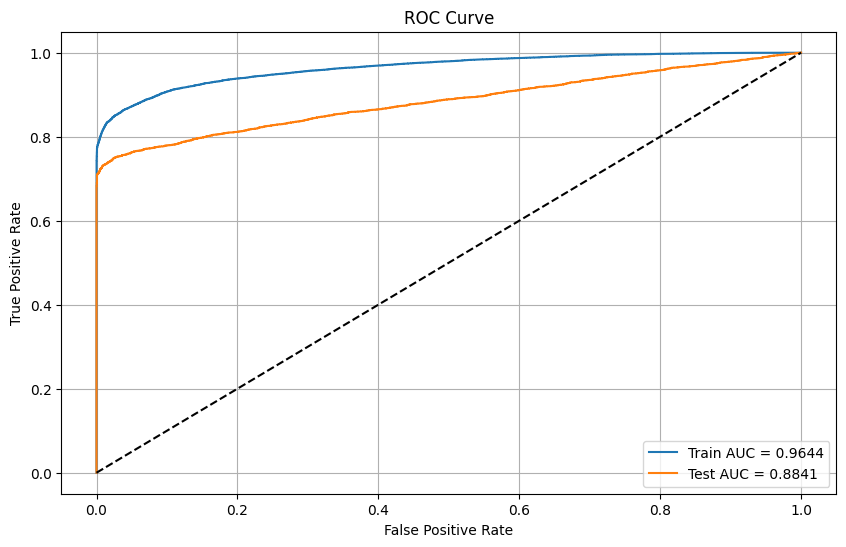

H-measure (Train): 0.7348
H-measure (Test) : 0.5505
Best TPR*(1-FPR): 0.8305 at threshold = 0.393


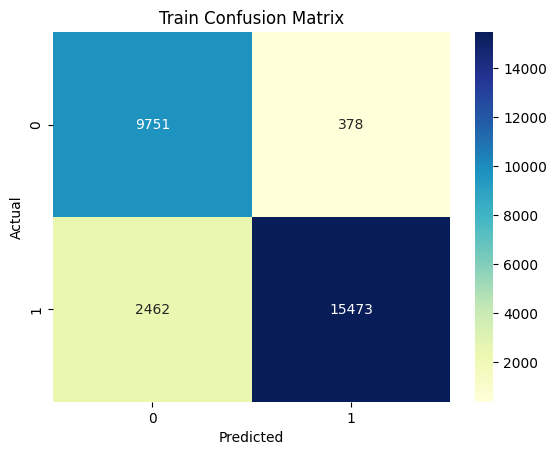

Best TPR*(1-FPR): 0.7310 at threshold = 0.480


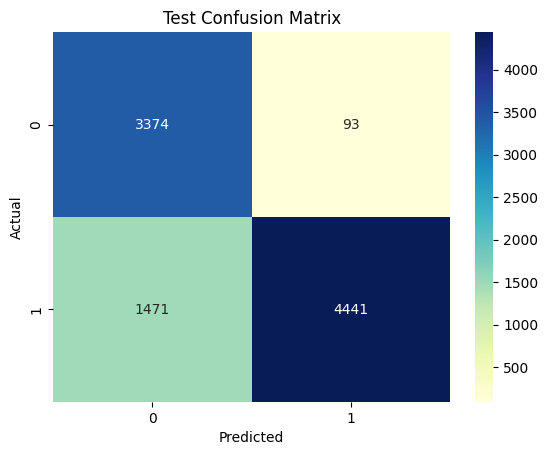


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      3467
           1       0.98      0.75      0.85      5912

    accuracy                           0.83      9379
   macro avg       0.84      0.86      0.83      9379
weighted avg       0.87      0.83      0.84      9379

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 200}
Best Cross-Validation Score (AUC): 0.9015189847766159


In [235]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

rf.fit(X_train_resample, y_train_resample)

evaluate_model(rf, X_train_resample, y_train_resample, X_test_resample, y_test_resample)

print("Best Parameters:", rf.best_params_)
print("Best Cross-Validation Score (AUC):", rf.best_score_)


### E-7) XGBOOST

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\hsham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


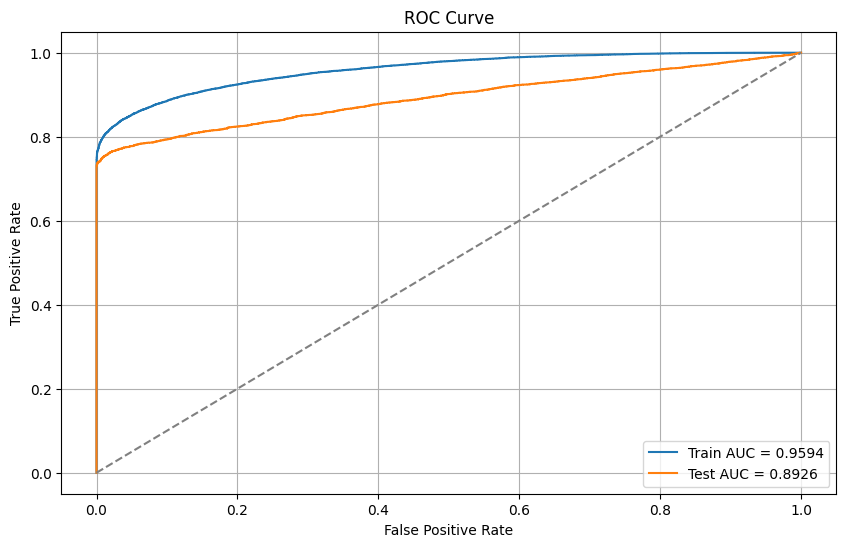

Best TPR*(1-FPR): 0.8100 at threshold = 0.509


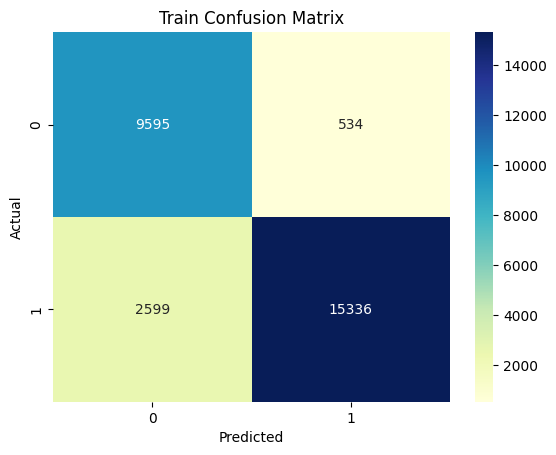

Best TPR*(1-FPR): 0.7486 at threshold = 0.596


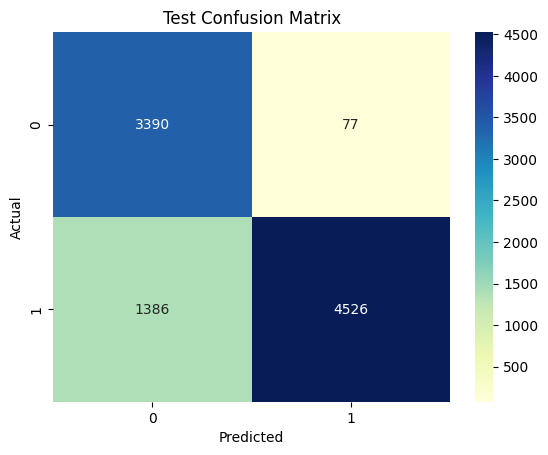

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.98      0.82      3467
           1       0.98      0.77      0.86      5912

    accuracy                           0.84      9379
   macro avg       0.85      0.87      0.84      9379
weighted avg       0.88      0.84      0.85      9379

H-measure (Train): 0.7045
H-measure (Test) : 0.5756
Best Parameters: {'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.7}
Best Cross-Validation Score (AUC): 0.9068


In [232]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.10, 0.15, 0.20],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.4, 0.5, 0.7]  # removed 0.0 (invalid for training)
}

xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)


xgb_model = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=5,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

xgb_model.fit(X_train_resample, y_train_resample)

evaluate_model(xgb_model, X_train_resample, y_train_resample, X_test_resample, y_test_resample)

print("Best Parameters:", xgb_model.best_params_)
print("Best Cross-Validation Score (AUC): {:.4f}".format(xgb_model.best_score_))


#### Which features affected the model more?

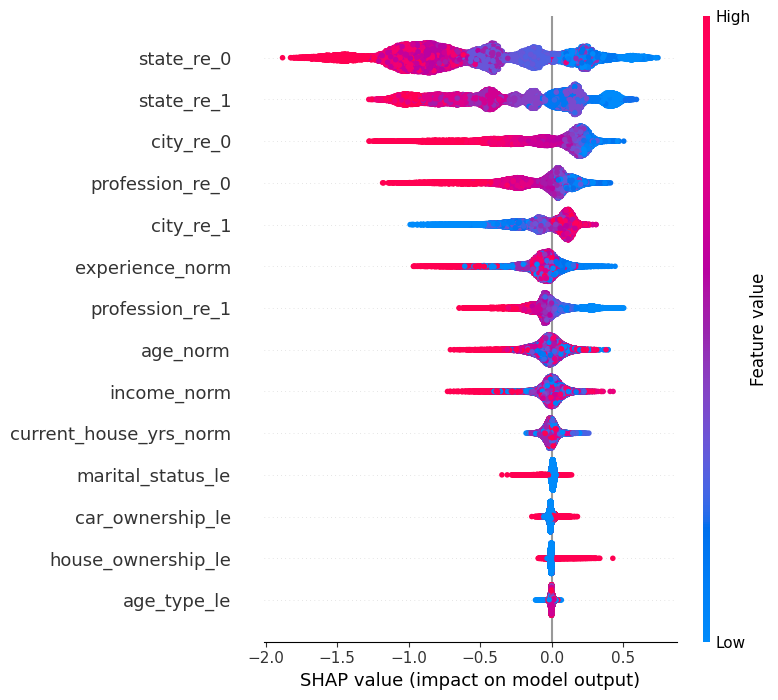

In [233]:
explainer = shap.Explainer(xgb_model.best_estimator_)
shap_values = explainer(X_train_stack_df)
shap.summary_plot(shap_values, X_train_stack_df)

#### **Conclusion:**
The model is heavily influenced by encoded location features (`state`, `city`), followed by `experience`, `age`, and `income`.
High-income, experienced individuals from certain states are less likely to default.

#### E-8) Comparison

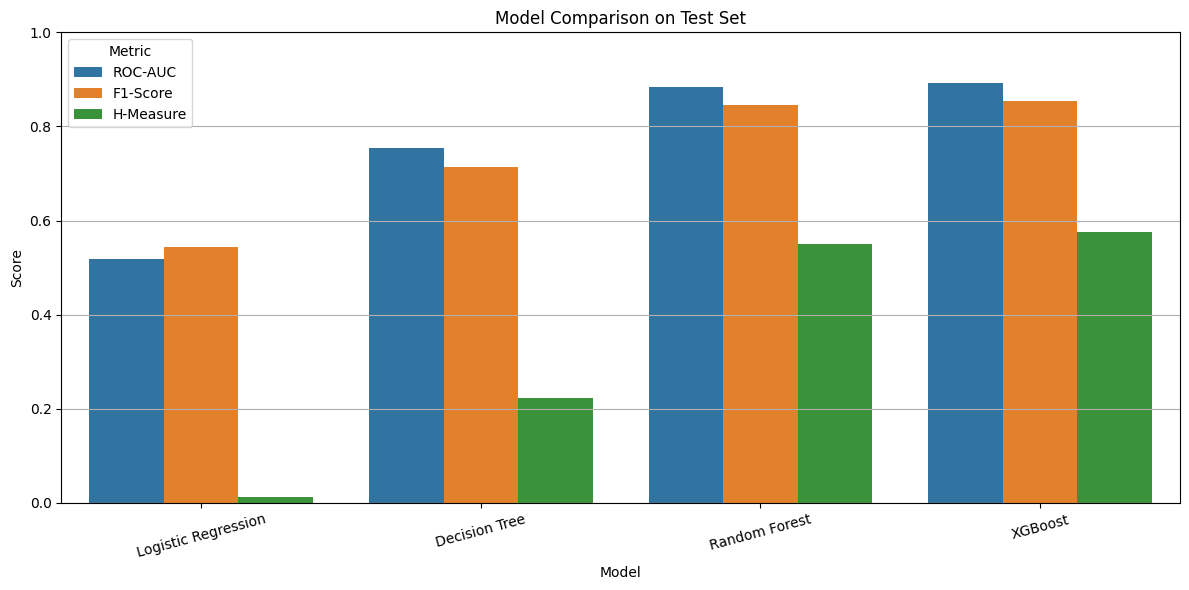

In [236]:
models = {
    "Logistic Regression": log_reg_cv,
    "Decision Tree": dt_model,
    "Random Forest": rf,
    "XGBoost": xgb_model
}

results = []

for name, model in models.items():
    y_test_proba = model.predict_proba(X_test_resample)[:, 1]
    y_test_pred = model.predict(X_test_resample)

    auc_score = roc_auc_score(y_test_resample, y_test_proba)
    f1 = f1_score(y_test_resample, y_test_pred)
    h = h_score(y_test_resample, y_test_proba)  

    results.append({
        "Model": name,
        "ROC-AUC": auc_score,
        "F1-Score": f1,
        "H-Measure": h
    })


results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Comparison on Test Set")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
